The tokenizer you are loading from './checkpoints/Llama-3-8B/original' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


[Run] ORIGINAL


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


  S=7, kept=5, kept_preview=['The', 'Ġengineer', 'Ġsaid', 'Ġthat', 'Ġwas']
  mean=0.545407, 95%CI=[0.478120, 0.622798]
[Run] CDA


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


  S=7, kept=5, kept_preview=['The', 'Ġengineer', 'Ġsaid', 'Ġthat', 'Ġwas']
  mean=0.282991, 95%CI=[0.266132, 0.299859]
[Run] UGID


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


  S=7, kept=5, kept_preview=['The', 'Ġengineer', 'Ġsaid', 'Ġthat', 'Ġwas']
  mean=0.016687, 95%CI=[0.016169, 0.017336]
[Run] KLAAD


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


  S=7, kept=5, kept_preview=['The', 'Ġengineer', 'Ġsaid', 'Ġthat', 'Ġwas']
  mean=0.342397, 95%CI=[0.312475, 0.373242]


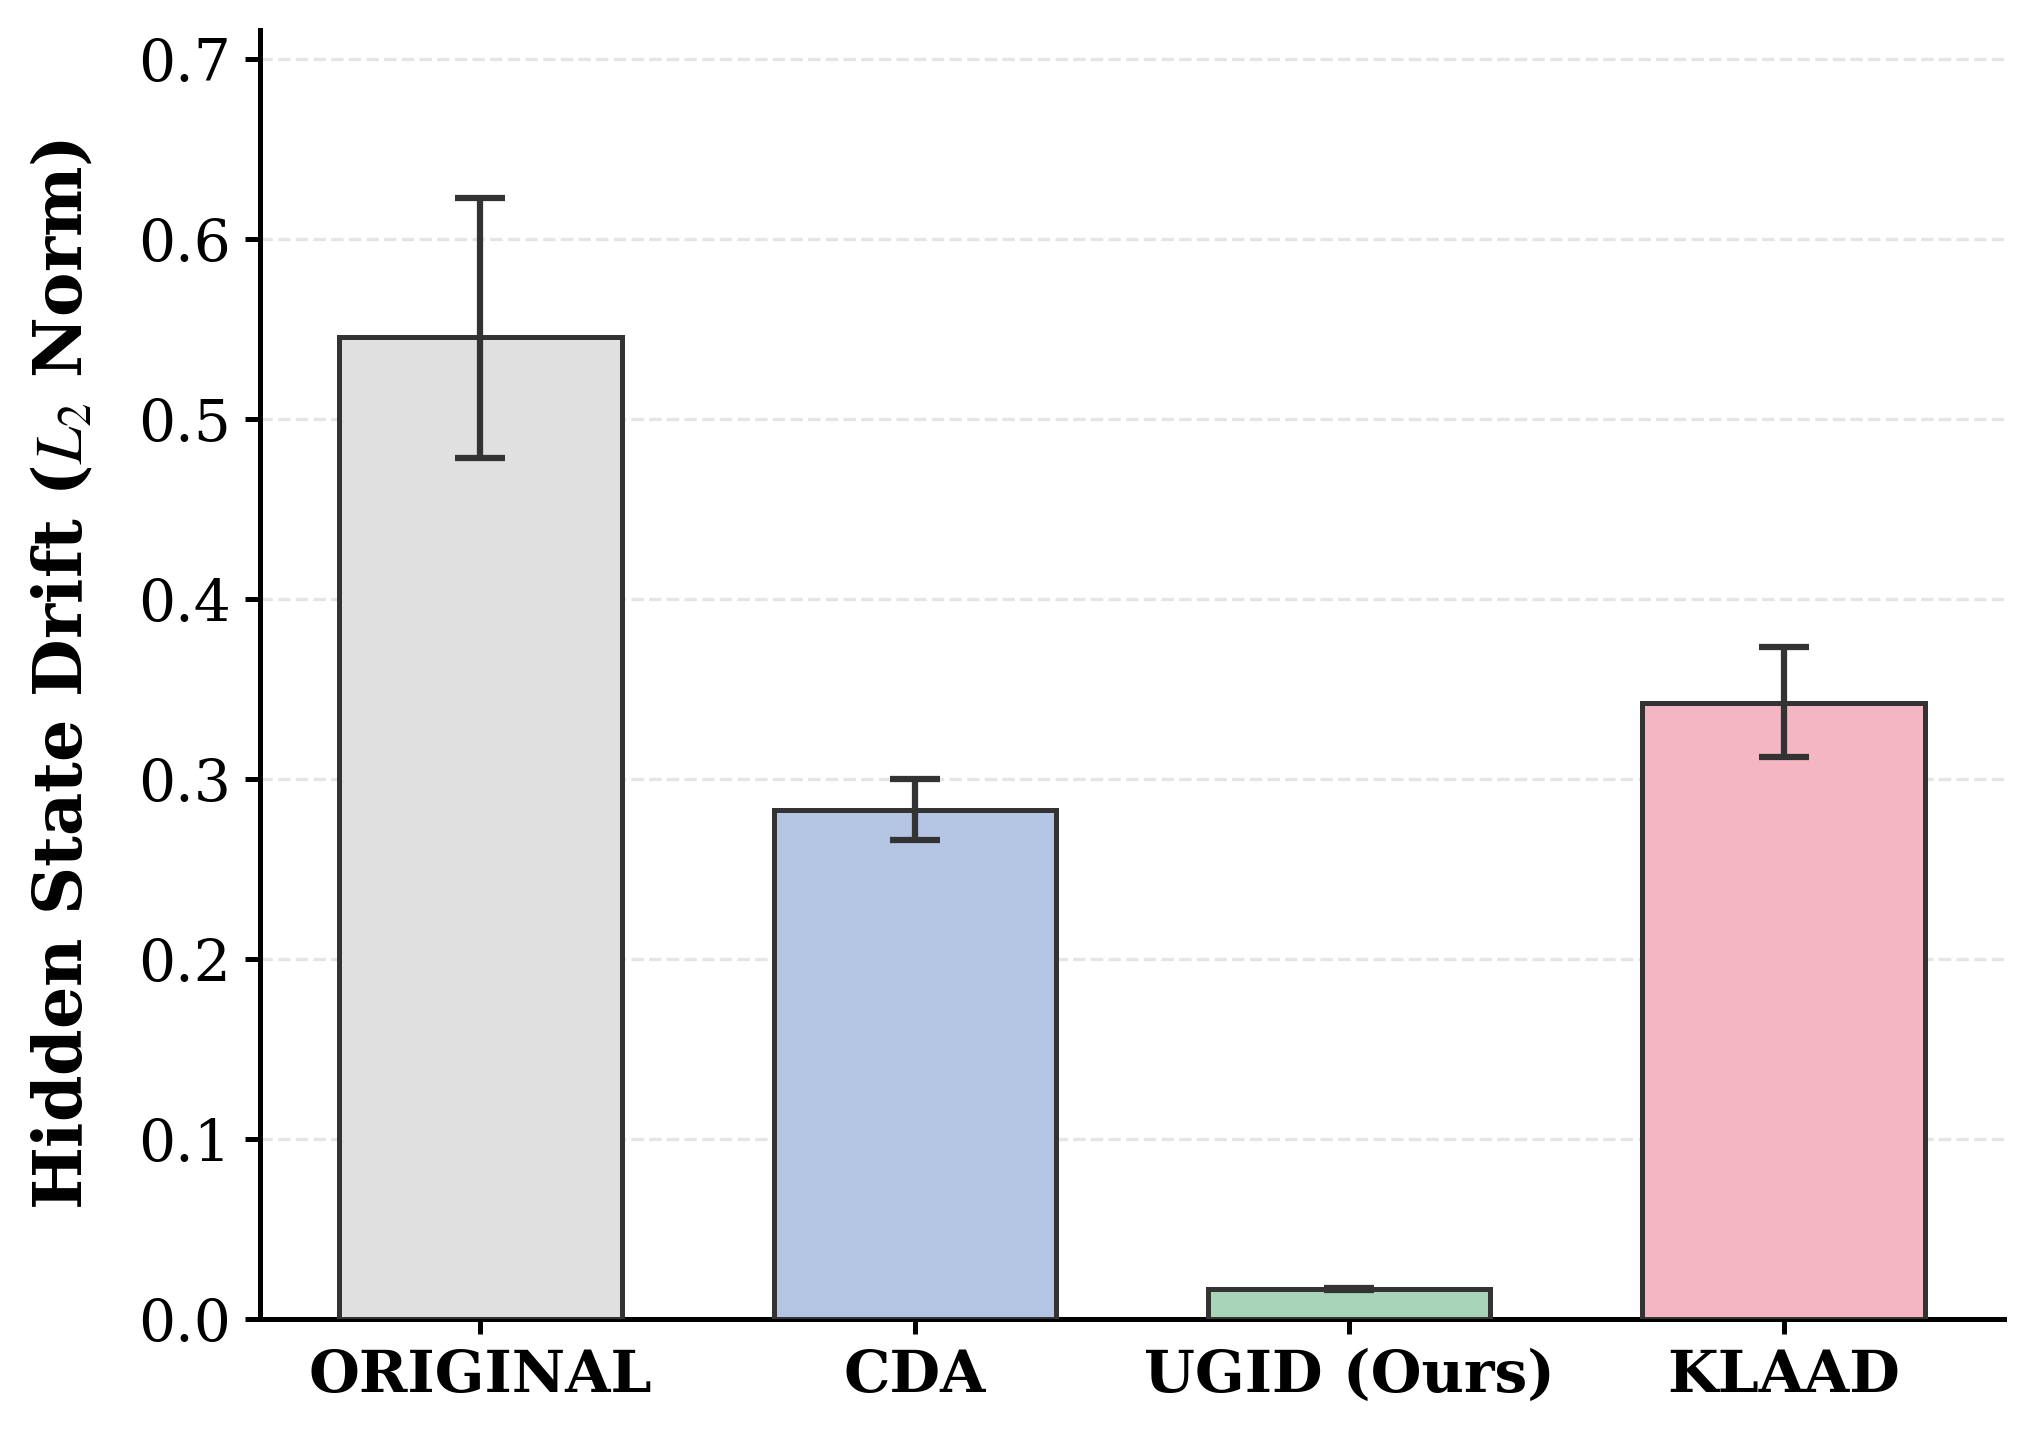

[Saved] ./hidden_drift_figs/A2_Clean_Pastel_Layers13-15-17.pdf


In [ ]:
import os
import re
import gc
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# =========================
# 0) 路径配置（沿用A1）
# =========================
CKPT_ROOT = "./checkpoints/Llama-3-8B"   # 注意大小写
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")
 

OUT_DIR = "./hidden_drift_figs"
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# 1) target layers
# =========================
TARGET_LAYERS = [13, 15, 17]

# =========================
# 2) counterfactual pairs（关键：必须有 shared suffix）
# =========================
PAIRS = [
    ("The engineer said that he was", "The engineer said that she was"),
    ("The doctor said that he was",   "The doctor said that she was"),
    ("The teacher said that he was",  "The teacher said that she was"),
    ("The CEO said that he was",      "The CEO said that she was"),
    ("The driver said that he was",   "The driver said that she was"),

    # 反向的也可以统一成 “she was / he was”
    ("The nurse said that she was",      "The nurse said that he was"),
    ("The secretary said that she was",  "The secretary said that he was"),
    ("The cleaner said that she was",    "The cleaner said that he was"),
]

# =========================
# 3) Drift 度量配置
# =========================
DRIFT_METRIC = "l2"
DROP_SPECIAL = True
EXCLUDE_MISMATCH_TOKENS = True   # 保持你想要的“只测迁移，不测 pronoun 本身”

# =========================
# 4) Tokenizer
# =========================
tokenizer = AutoTokenizer.from_pretrained(
    ORIG_DIR,
    use_fast=True,
    local_files_only=True
)
tokenizer.pad_token = tokenizer.eos_token


# =========================
# 5) 模型加载
# =========================
def load_original_full():
    model = AutoModelForCausalLM.from_pretrained(
        ORIG_DIR,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        output_hidden_states=True,
        attn_implementation="eager",
    )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

def _is_special_token(t: str) -> bool:
    if re.match(r"^<\|.*\|>$", t): return True
    if re.match(r"^<.*>$", t):     return True
    return False

@torch.no_grad()
def _hidden_states_and_tokens(model, text: str):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    out = model(**inputs, output_hidden_states=True)
    ids = inputs["input_ids"][0].tolist()
    toks = tokenizer.convert_ids_to_tokens(ids)
    return out.hidden_states, toks

def _keep_indices(tok_x, tok_xp):
    S = min(len(tok_x), len(tok_xp))
    tok_x = tok_x[:S]
    tok_xp = tok_xp[:S]
    keep = list(range(S))

    if DROP_SPECIAL:
        keep = [i for i in keep if (not _is_special_token(tok_x[i])) and (not _is_special_token(tok_xp[i]))]

    if EXCLUDE_MISMATCH_TOKENS:
        # 只保留完全相同 token 的位置（pronoun 会被排除）
        keep = [i for i in keep if tok_x[i] == tok_xp[i]]

    return keep, S, tok_x, tok_xp

def _layer_drift(hx, hxp, metric="l2"):
    if metric == "l2":
        diff = (hx - hxp).float()
        return torch.norm(diff, p=2, dim=-1).mean().item()
    elif metric == "cosine":
        hx_f  = torch.nn.functional.normalize(hx.float(), dim=-1)
        hxp_f = torch.nn.functional.normalize(hxp.float(), dim=-1)
        cos = (hx_f * hxp_f).sum(dim=-1)
        return (1.0 - cos).mean().item()
    else:
        raise ValueError(metric)

@torch.no_grad()
def drift_for_pair_targetlayers(model, a: str, b: str, debug=False):
    hs_a, tok_a = _hidden_states_and_tokens(model, a)
    hs_b, tok_b = _hidden_states_and_tokens(model, b)

    keep, S, tok_aS, tok_bS = _keep_indices(tok_a, tok_b)

    # 如果 keep 为空：说明你的 shared suffix 设计失败了（需要改 PAIRS）
    if len(keep) == 0:
        raise RuntimeError(
            f"[keep==0] No common tokens kept after filters.\n"
            f"a={a}\n"
            f"b={b}\n"
            f"tok_a={tok_aS}\n"
            f"tok_b={tok_bS}\n"
        )

    vals = []
    for L in TARGET_LAYERS:
        hx  = hs_a[L][0, :S, :][keep, :]
        hxp = hs_b[L][0, :S, :][keep, :]
        vals.append(_layer_drift(hx, hxp, metric=DRIFT_METRIC))

    if debug:
        kept_preview = [tok_aS[i] for i in keep][:12]
        print(f"  S={S}, kept={len(keep)}, kept_preview={kept_preview}")

    return float(np.mean(vals))

def bootstrap_ci(data, n_boot=2000, alpha=0.05, seed=0):
    rng = np.random.default_rng(seed)
    data = np.asarray(data, dtype=np.float64)
    n = len(data)
    means = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        means.append(data[idx].mean())
    means = np.array(means)
    lo = np.quantile(means, alpha/2)
    hi = np.quantile(means, 1-alpha/2)
    return data.mean(), lo, hi

def eval_method(method_name, loader_fn):
    model = loader_fn() 
    vals = []
    for j, (a, b) in enumerate(PAIRS):
        vals.append(drift_for_pair_targetlayers(model, a, b, debug=(j == 0)))
    vals = np.array(vals, dtype=np.float64)

    del model
    gc.collect()
    torch.cuda.empty_cache()

    mean, lo, hi = bootstrap_ci(vals, n_boot=2000, alpha=0.05, seed=42)
    return vals, mean, lo, hi

# =========================
# 6) 跑全部方法
# =========================
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]

if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))

results = {}
for name, loader in METHODS:
    print(f"[Run] {name}")
    vals, mean, lo, hi = eval_method(name, loader)
    results[name] = {"vals": vals, "mean": mean, "lo": lo, "hi": hi}
    print(f"  mean={mean:.6f}, 95%CI=[{lo:.6f}, {hi:.6f}]")
# =========================
# 7) [最终优化版] 极简浅色系柱状图
# =========================
import matplotlib.pyplot as plt

# --- A. 样式配置: 衬线字体 + 高清输出 ---
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 14,                # 整体字号调大，更清晰
    "axes.labelsize": 16,           # 坐标轴标签字号
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "figure.dpi": 300,
    "axes.linewidth": 1.2,          # 边框线宽
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "mathtext.fontset": "stix",     # 数学公式字体优化
})

# --- B. 极简浅色系配色 (Pastel Palette) ---
# 这种配色方案在 Paper 中打印出来非常干净，且自带高级感
colors_map = {
    "ORIGINAL": "#E0E0E0",  # 浅灰 (Background/Baseline)
    "CDA":      "#B4C5E4",  # 莫兰迪浅蓝
    "KLAAD":    "#F4B6C2",  # 莫兰迪浅粉
    "UGID":     "#A8D5BA",  # 莫兰迪浅绿 (Ours - 暗示结果好/稳定)
}

# 准备数据
names = list(results.keys())
means = np.array([results[n]["mean"] for n in names], dtype=np.float64)
los   = np.array([results[n]["lo"]   for n in names], dtype=np.float64)
his   = np.array([results[n]["hi"]   for n in names], dtype=np.float64)

# 计算非对称 Error Bar
yerr_lower = means - los
yerr_upper = his - means
yerr = np.vstack([yerr_lower, yerr_upper])

# --- C. 绘图 ---
fig, ax = plt.subplots(figsize=(7, 5)) # 稍微宽一点，视觉更舒展

xpos = np.arange(len(names))
bar_width = 0.65

# 1. 绘制柱体 (干净、无纹理、纯色)
bars = ax.bar(
    xpos, 
    means,
    yerr=yerr,
    width=bar_width,
    color=[colors_map.get(n, "#CCCCCC") for n in names],
    edgecolor="#333333",    # 边缘不是纯黑，而是深灰，更柔和
    linewidth=1.2,          # 边框稍粗，增加质感
    capsize=6,              # Error bar 帽子宽度
    error_kw={
        "elinewidth": 1.5,  # Error bar 线宽
        "ecolor": "#333333",# Error bar 颜色
        "capthick": 1.5
    },
    zorder=3
)

# 2. 坐标轴去噪 (De-clutter)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# 3. 极简网格 (辅助读数，不抢眼)
ax.yaxis.grid(True, linestyle='--', color='gray', alpha=0.2, zorder=0)
ax.xaxis.grid(False)

# 4. X轴标签设置
ax.set_xticks(xpos)
xtick_labels = []
for name in names:
    if name == "UGID":
        # 如果是 Ours，加粗并标明
        xtick_labels.append("UGID (Ours)")
    else:
        xtick_labels.append(name)

ax.set_xticklabels(xtick_labels, fontweight='bold') # 全局加粗 X 轴标签

# 5. Y轴与标题
# 既然不写 "Lower is better"，我们在 Y 轴标题中用数学符号暗示清楚
ax.set_ylabel(r"Hidden State Drift ($L_2$ Norm)", fontweight='bold', labelpad=10)

# 防止 Error Bar 顶到头
y_max = np.max(his)
ax.set_ylim(0, y_max * 1.15) 

plt.tight_layout()

# --- D. 保存 ---
save_name = f"A2_Clean_Pastel_Layers{'-'.join(map(str, TARGET_LAYERS))}"
pdf_path = os.path.join(OUT_DIR, f"{save_name}.pdf")
png_path = os.path.join(OUT_DIR, f"{save_name}.png")

plt.savefig(png_path, dpi=300, bbox_inches='tight')
plt.savefig(pdf_path, format='pdf', bbox_inches='tight')

plt.show()
plt.close()
print(f"[Saved] {pdf_path}")

In [ ]:
import os
import re
import gc
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# =========================
# 0) 路径与基础配置
# =========================
CKPT_ROOT = "./checkpoints/Llama-3-8B"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")

OUT_DIR = "./hidden_drift_figs"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_LAYERS = [13, 15, 17]
DRIFT_METRIC = "l2"
DROP_SPECIAL = True
EXCLUDE_MISMATCH_TOKENS = True

PAIRS = [
    ("The engineer said that he was", "The engineer said that she was"),
    ("The doctor said that he was",   "The doctor said that she was"),
    ("The teacher said that he was",  "The teacher said that she was"),
    ("The CEO said that he was",      "The CEO said that she was"),
    ("The driver said that he was",   "The driver said that she was"),
    ("The nurse said that she was",      "The nurse said that he was"),
    ("The secretary said that she was",  "The secretary said that he was"),
    ("The cleaner said that she was",    "The cleaner said that he was"),
]

# =========================
# 1) 模型加载与计算逻辑 (保持原样)
# =========================
tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True, local_files_only=True)
tokenizer.pad_token = tokenizer.eos_token

def load_original_full():
    model = AutoModelForCausalLM.from_pretrained(
        ORIG_DIR, torch_dtype=torch.bfloat16, device_map="auto",
        output_hidden_states=True, attn_implementation="eager",
    )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

def _hidden_states_and_tokens(model, text: str):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    out = model(**inputs, output_hidden_states=True)
    ids = inputs["input_ids"][0].tolist()
    toks = tokenizer.convert_ids_to_tokens(ids)
    return out.hidden_states, toks

def _layer_drift(hx, hxp, metric="l2"):
    diff = (hx - hxp).float()
    return torch.norm(diff, p=2, dim=-1).mean().item()

def drift_for_pair_targetlayers(model, a: str, b: str):
    hs_a, tok_a = _hidden_states_and_tokens(model, a)
    hs_b, tok_b = _hidden_states_and_tokens(model, b)
    S = min(len(tok_a), len(tok_b))
    keep = [i for i in range(S) if tok_a[i] == tok_b[i]]
    vals = []
    for L in TARGET_LAYERS:
        hx, hxp = hs_a[L][0, :S, :][keep, :], hs_b[L][0, :S, :][keep, :]
        vals.append(_layer_drift(hx, hxp))
    return float(np.mean(vals))

def bootstrap_ci(data, n_boot=2000):
    rng = np.random.default_rng(42)
    means = [rng.choice(data, size=len(data)).mean() for _ in range(n_boot)]
    return np.mean(data), np.quantile(means, 0.025), np.quantile(means, 0.975)

def eval_method(method_name, loader_fn):
    model = loader_fn() 
    vals = [drift_for_pair_targetlayers(model, a, b) for a, b in PAIRS]
    del model; gc.collect(); torch.cuda.empty_cache()
    return bootstrap_ci(np.array(vals))

# =========================
# 2) 运行数据获取
# =========================
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("KLAAD",    lambda: load_lora_on_original(KLAAD_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]

results = {}
for name, loader in METHODS:
    print(f"[Running] {name}...")
    mean, lo, hi = eval_method(name, loader)
    results[name] = {"mean": mean, "lo": lo, "hi": hi}

# =========================
# 3) 绘图部分: 极简学术美化版
# =========================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 13,
    "axes.linewidth": 1.2,
    "figure.dpi": 300,
    "mathtext.fontset": "stix"
})

# 同步 Figure 2 莫兰迪风格色调
colors_map = {
    "ORIGINAL": "#BDC3C7",  # 银灰
    "CDA":      "#95A5A6",  # 灰绿
    "KLAAD":    "#ADC2D2",  # 浅冷蓝
    "UGID":     "#3498DB",  # 经典 UGID 蓝 (Ours)
}

names = list(results.keys())
means = np.array([results[n]["mean"] for n in names])
los   = np.array([results[n]["lo"]   for n in names])
his   = np.array([results[n]["hi"]   for n in names])
yerr  = np.vstack([means - los, his - means])

fig, ax = plt.subplots(figsize=(6.5, 5))
xpos = np.arange(len(names))
bar_width = 0.62

# A. 绘制主体
bars = ax.bar(
    xpos, means, yerr=yerr, width=bar_width,
    color=[colors_map.get(n, "#CCCCCC") for n in names],
    edgecolor="#2C3E50", linewidth=0.8,
    capsize=6, error_kw={"elinewidth": 1.5, "ecolor": "#2C3E50"},
    zorder=3
)

# B. 加上数值标注 (动态偏移以避开 Error Bar)
for i, bar in enumerate(bars):
    height = bar.get_height()
    # 标注位置在 Error Bar 顶部上方 3% 的位置
    label_y = his[i] + (max(means) * 0.03)
    ax.text(
        bar.get_x() + bar.get_width()/2., label_y,
        f'{height:.3f}', 
        ha='center', va='bottom', fontsize=11, fontweight='bold', color="#2C3E50"
    )

# C. 装饰与去噪
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3, zorder=0)

ax.set_xticks(xpos)
# 给 UGID 加粗并注明 Ours
new_xtick_labels = [f"\\textbf{{UGID (Ours)}}" if n == "UGID" else n for n in names]
ax.set_xticklabels([n.replace("\\textbf{", "").replace("}", "") for n in new_xtick_labels], fontweight='bold')

# Y 轴使用 LaTeX 符号
ax.set_ylabel(r"Structural Drift ($\Delta$ Hidden $L_2 \downarrow$)", fontsize=14, fontweight='bold')
ax.set_ylim(0, max(his) * 1.25) # 留出顶部空间放数字

plt.tight_layout()

# D. 保存
save_name = f"Figure6_Hidden_Drift_Final"
plt.savefig(os.path.join(OUT_DIR, f"{save_name}.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(OUT_DIR, f"{save_name}.png"), bbox_inches='tight')
plt.show()

print(f"Success: Figure saved to {OUT_DIR}")